一个合格的 SQL Agent 不是直接写 SQL，而是遵循以下步骤：

1. List Tables: 先看看库里有哪些表？
2. Get Schema: 针对用户问题，查询相关表的字段定义（Schema）。
3. Check Query: 写出 SQL 后，先用工具检查语法错误。
4. Execute: 执行查询。
5. Answer: 根据数据回答问题。


关键组件
1. SQLDatabaseToolkit: 这是一个工具箱，它自动为 Agent 提供了四个工具：
2. sql_db_list_tables: 列出表名。
3. sql_db_schema: 查看表结构。
4. sql_db_query: 执行 SQL。
5. sql_db_query_checker: 检查 SQL 语法。
HumanInTheLoopMiddleware: 中间件。它允许我们在特定的工具（如 sql_db_query）执行之前强行暂停程序，等待人类批准。

In [7]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI  # <--- 注意这里是 langchain_openai

# 加载 .env 文件
load_dotenv(override=True)

# 从环境变量获取配置
# 假设你的 .env 文件里是：
# OPENAI_API_KEY=sk-xxxx
# OPENAI_API_BASE=https://api.proxy.com/v1

api_key = os.getenv("OPENAI_API_KEY")
base_url = os.getenv("OPENAI_API_BASE") # 代理商地址

model = ChatOpenAI(model="gpt-5-mini")

2. Configure the database

In [8]:
import requests, pathlib
#loading the chinook database, which is a sample database that represents a digital media store.
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"
local_path = pathlib.Path("Chinook.db")

if local_path.exists():
    print(f"{local_path} already exists, skipping download.")
else:
    response = requests.get(url)
    if response.status_code == 200:
        local_path.write_bytes(response.content)
        print(f"File downloaded and saved as {local_path}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")

Chinook.db already exists, skipping download.


用langchain_community包中可用的便利SQL数据库封装来与数据库进行交互。这个封装提供了一个简单的接口来执行SQL查询并获取结果：

In [9]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}')

Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


3. 为数据库交互添加工具

使用langchain_community包中可用的SQLDatabase包装器与数据库交互。该包装器提供了一个简单的接口来执行SQL查询并获取结果

In [10]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=model)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



4. 使用 create_agent

使用 create_agent 以最少的代码构建 ReAct 代理。该代理将解释请求并生成一个 SQL 命令，工具将执行该命令。如果命令出现错误，错误消息将返回给模型。模型可以检查原始请求和新的错误消息，然后生成新的命令。这个过程可以持续进行，直到 LLM 成功生成命令或达到结束计数。向模型提供反馈 - 在这种情况下是错误消息 - 的这种模式非常强大。
用描述性的系统提示初始化代理，以自定义其行为：

In [11]:
system_prompt = """
You are an agent designed to interact with a SQL database. Your answer needs to use chinese.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

from langchain.agents import create_agent


agent = create_agent(
    model,
    tools,
    system_prompt=system_prompt,
)

5. run agent

In [12]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_BiodQaUtRCijHYv0kfoAnEf6)
 Call ID: call_BiodQaUtRCijHYv0kfoAnEf6
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_pPnM9WH78jEtyerydF4RipXQ)
 Call ID: call_pPnM9WH78jEtyerydF4RipXQ
  Args:
    table_names: Genre, Track
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre 

可以使用langsmith 监控 查看

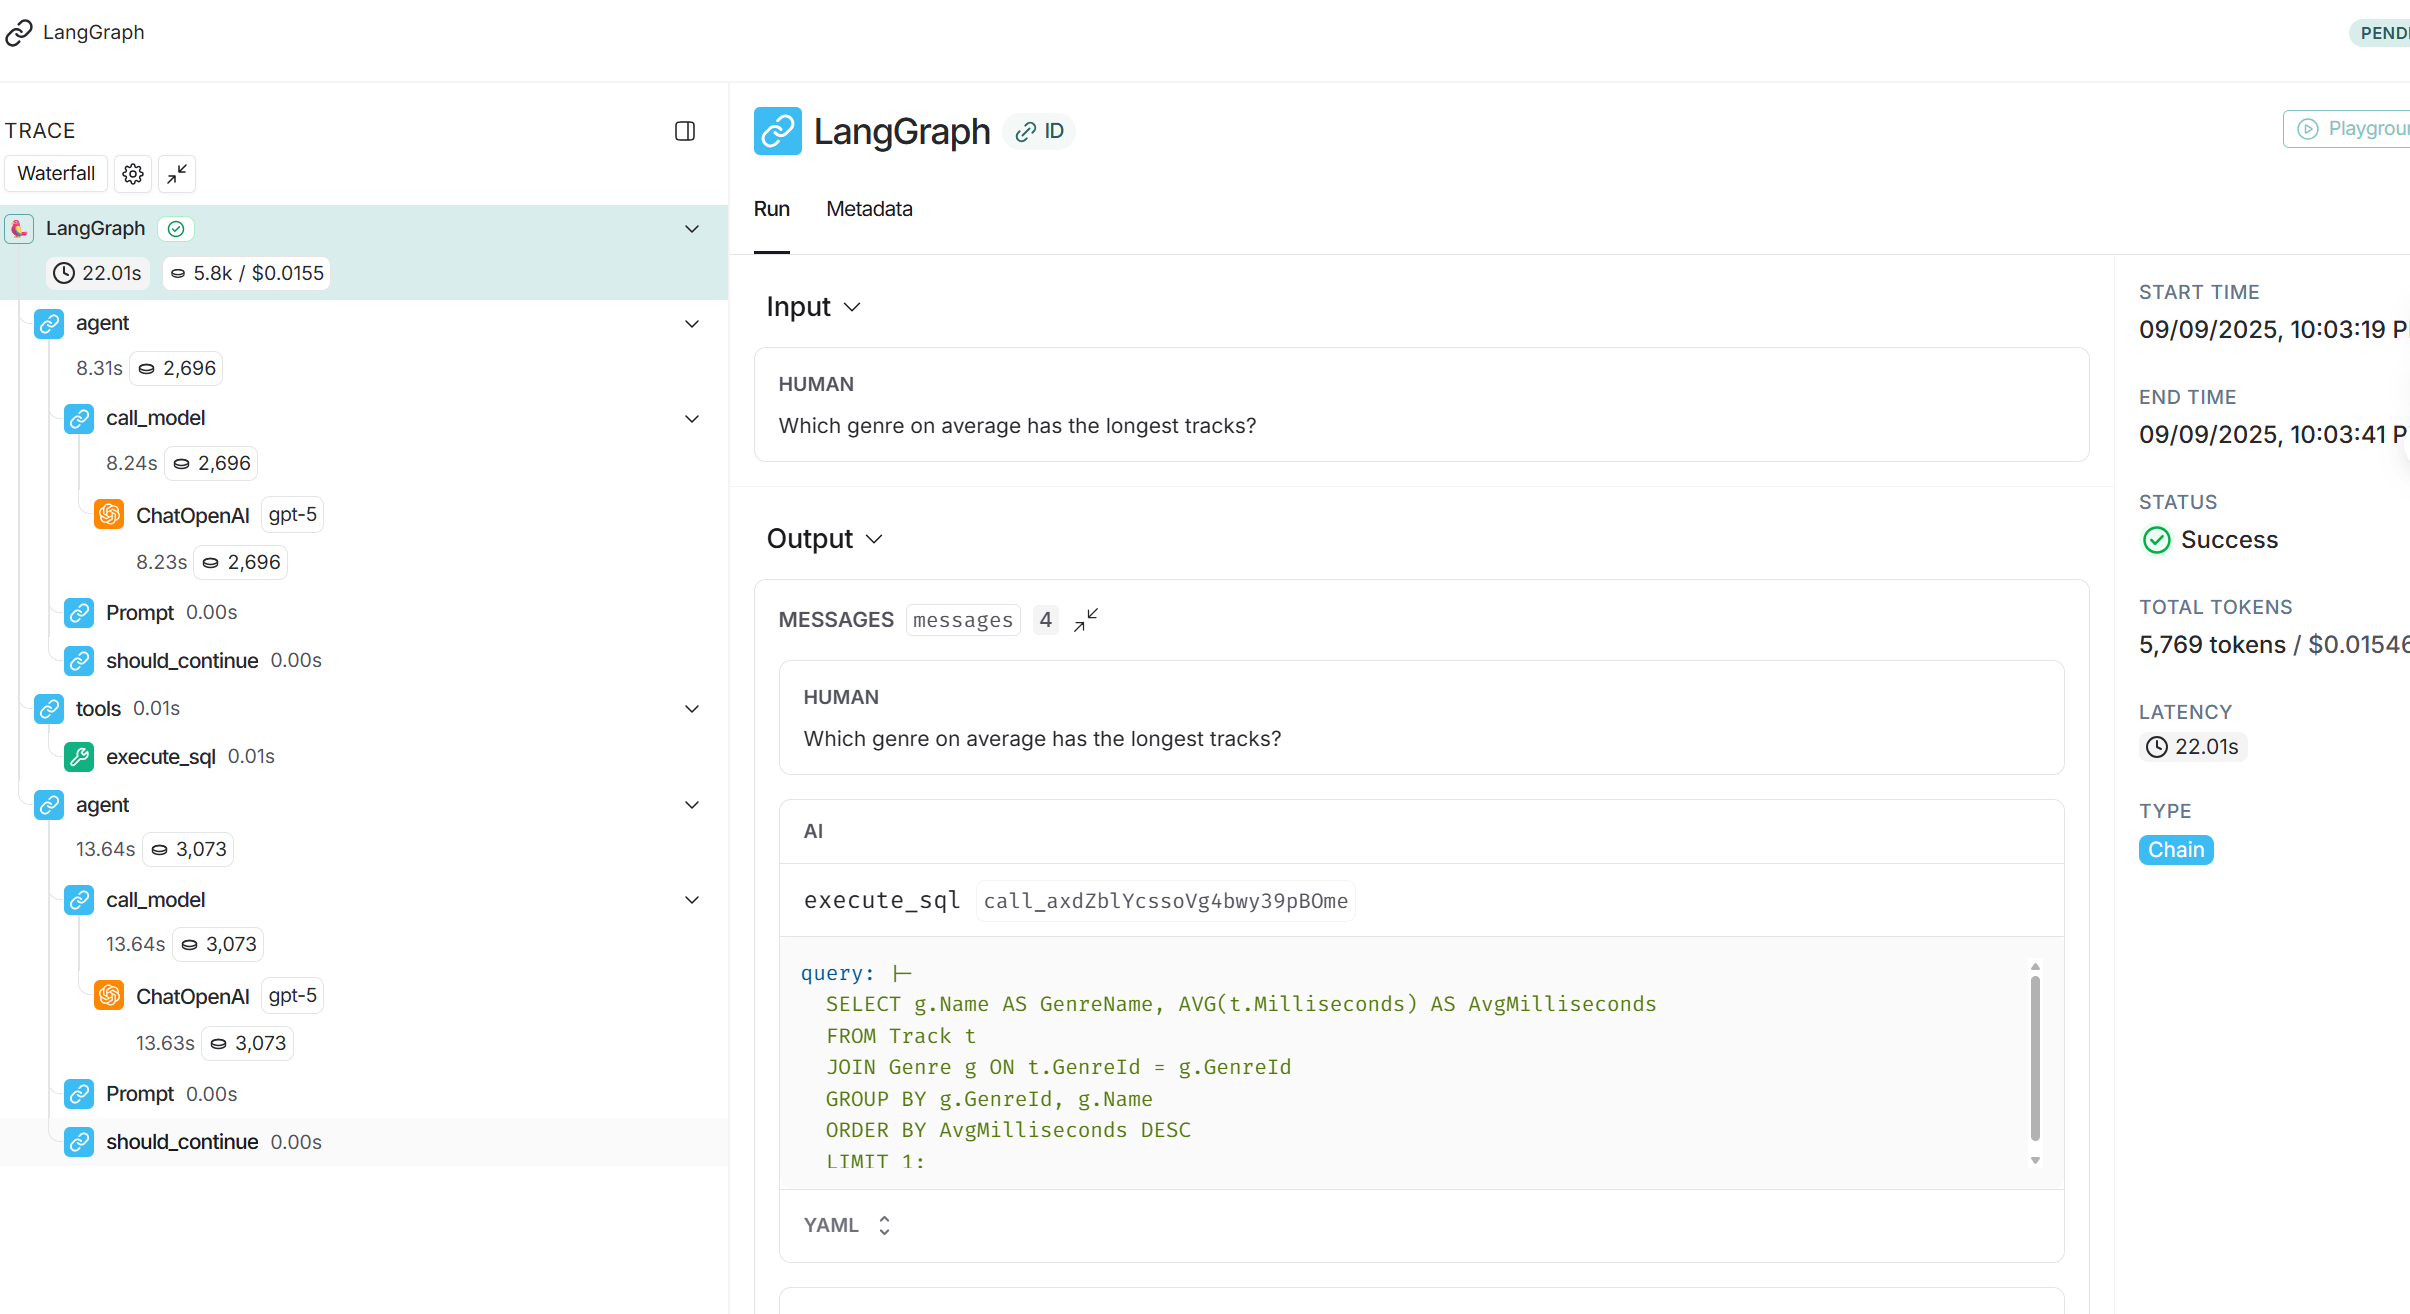

5. 可选 studio

6. 使用人工干预的中间件来审查

In [13]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver


agent = create_agent(
    model,
    tools,
    system_prompt=system_prompt,
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={"sql_db_query": True},
            description_prefix="Tool execution pending approval",
        ),
    ],
    checkpointer=InMemorySaver(),
)


question = "Which genre on average has the longest tracks?"
config = {"configurable": {"thread_id": "1"}}

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    config,
    stream_mode="values",
):
    if "messages" in step:
        step["messages"][-1].pretty_print()
    elif "__interrupt__" in step:
        print("INTERRUPTED:")
        interrupt = step["__interrupt__"][0]
        for request in interrupt.value["action_requests"]:
            print(request["description"])
    else:
        pass


    from langgraph.types import Command

for step in agent.stream(
    Command(resume={"decisions": [{"type": "approve"}]}),
    config,
    stream_mode="values",
):
    if "messages" in step:
        step["messages"][-1].pretty_print()
    elif "__interrupt__" in step:
        print("INTERRUPTED:")
        interrupt = step["__interrupt__"][0]
        for request in interrupt.value["action_requests"]:
            print(request["description"])
    else:
        pass

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_sVdkE28KjPUWA9Oq9CxPGVik)
 Call ID: call_sVdkE28KjPUWA9Oq9CxPGVik
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_xIUkvaDVoIaiH5dm9fjRlSyn)
 Call ID: call_xIUkvaDVoIaiH5dm9fjRlSyn
  Args:
    table_names: Track, Genre
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre table:
GenreId	N